# Regressions and Linear Models in Python

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## Set up data

In [2]:
# Read in data
train = pd.read_csv("TrainingSet2.csv")
validate = pd.read_csv("ValidationSet2.csv")

In [3]:
# Drop entity condition variables
to_drop = ["Unnamed: 0", "entity_condition_1", "entity_condition_2", "entity_condition_3", "entity_condition_4"]
train.drop(to_drop, axis=1, inplace=True)
validate.drop(to_drop, axis=1, inplace=True)

In [4]:
train.head()

,education,sex,age,pod,marital_status,race,hispanic,A41,C15,C16,...,R06,R09,R53,R54,R56,R57,R62,R64,R68,R99
0,high school,F,91,Home,W,White,Non-Hispanic,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,high school,M,82,Home,M,White,Non-Hispanic,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,high school,F,89,Home,W,White,Non-Hispanic,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bachelor,F,84,Nursing Home,M,White,Non-Hispanic,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,high school,F,84,Nursing Home,M,White,Non-Hispanic,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Make the dummies
train = pd.concat([pd.get_dummies(train["education"]), train.drop("education", axis=1)], axis=1)
train = pd.concat([pd.get_dummies(train["marital_status"]), train.drop("marital_status", axis=1)], axis=1)
train = pd.concat([pd.get_dummies(train["race"]), train.drop("race", axis=1)], axis=1)
train = pd.concat([pd.get_dummies(train["hispanic"]), train.drop("hispanic", axis=1)], axis=1)
train["sex"].replace("M", 0, inplace=True)
train["sex"].replace("F", 1, inplace=True)

validate = pd.concat([pd.get_dummies(validate["education"]), validate.drop("education", axis=1)], axis=1)
validate = pd.concat([pd.get_dummies(validate["marital_status"]), validate.drop("marital_status", axis=1)], axis=1)
validate = pd.concat([pd.get_dummies(validate["race"]), validate.drop("race", axis=1)], axis=1)
validate = pd.concat([pd.get_dummies(validate["hispanic"]), validate.drop("hispanic", axis=1)], axis=1)
validate["sex"].replace("M", 0, inplace=True)
validate["sex"].replace("F", 1, inplace=True)

In [5]:
train = train.drop("pod", axis=1)
validate = validate.drop("pod", axis=1)

In [7]:
train.head()

,C./S. American,Cuban,Mexican,Non-Hispanic,Other Hispanic,Puerto Rican,Japanese,American Indian,Asian Indian,Black,...,R06,R09,R53,R54,R56,R57,R62,R64,R68,R99
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Now add in the interaction terms

Column 33 is the first diease column, then all the way to the end. Column 32 is age. Column 19 starts marital status, 22 ends marital status

In [6]:
# Columns we want to interact
relationship_cols = list(train.columns[19:23])
disease_cols = list(train.columns[33:]) 

In [7]:
# Make the interaction terms
i = 1
for rcol in relationship_cols:
    for dcol in disease_cols:
        name = "Feat_" + str(i)
        train[name] = train[rcol]*train[dcol]
        validate[name] = validate[rcol]*validate[dcol]
        i += 1
        if i%50 == 0:
            print "tranforming feature:", i

tranforming feature: 50
tranforming feature: 100
tranforming feature: 150
tranforming feature: 200
tranforming feature: 250
tranforming feature: 300
tranforming feature: 350
tranforming feature: 400


## Lasso Model

In [8]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

In [9]:
# Scale the data (trainig)
scaler = StandardScaler()
scaler.fit(train.drop("age", axis=1))
sdat = scaler.transform(train.drop("age", axis=1))

In [10]:
# Scale the validation set
scaler = StandardScaler()
scaler.fit(validate.drop("age", axis=1))
vdat = scaler.transform(validate.drop("age", axis=1))

In [11]:
VTruth = validate["age"]

In [12]:
n = train.shape[0]

In [87]:
(n/10)/train.shape[1]

139

Now we can cross validate on the tuning parameter:

In [110]:
cv_errors = []
min_error = np.Inf
best_alpha = 0
#alphas = [.01, .03, .05, .07, .09, .1, .5, 1, 1.5, 2, 3, 4, 6, 9, 10, 15, 20, 25, 30, 50, 70, 100]
#alphas = [.006,.008, .009, .01, .011, .013, .015, .017, .02, .022]
#alphas = [.0001, .0005, .0009, .001, .005, .009, .01, .011, .013, .015, .017, .02, .022, .025, .029, .033, .04]
alphas = arange(0.00001,.001,.00005)
for a in alphas:
    print "Fitting with alpha =", a
    # fit the lasso
    l1 = linear_model.Lasso(alpha=a, max_iter=5000) #had a convergence warning
    l1.fit(sdat[1:int(n/10)], train["age"][1:int(n/10)])
    
    predictions = l1.predict(vdat)
    error = np.mean((predictions - VTruth)**2)
    cv_errors.append(error)
    
    if error < min_error:
        best_alpha = a
        min_error = error
        
print "Best alpha is:", best_alpha

Fitting with alpha = 1e-05
Fitting with alpha = 6e-05
Fitting with alpha = 0.00011
Fitting with alpha = 0.00016
Fitting with alpha = 0.00021
Fitting with alpha = 0.00026
Fitting with alpha = 0.00031
Fitting with alpha = 0.00036
Fitting with alpha = 0.00041
Fitting with alpha = 0.00046
Fitting with alpha = 0.00051
Fitting with alpha = 0.00056
Fitting with alpha = 0.00061
Fitting with alpha = 0.00066
Fitting with alpha = 0.00071
Fitting with alpha = 0.00076
Fitting with alpha = 0.00081
Fitting with alpha = 0.00086
Fitting with alpha = 0.00091
Fitting with alpha = 0.00096
Best alpha is: 1e-05


In [111]:
min_error

109.64156049221874

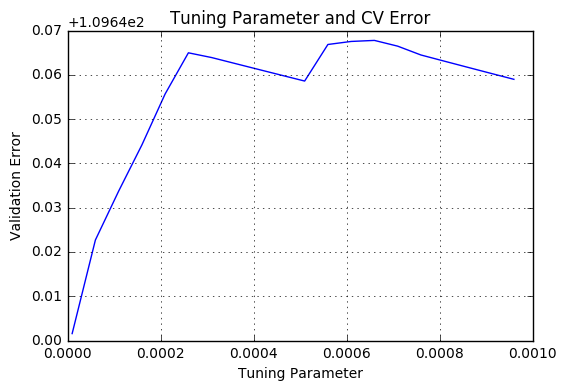

In [113]:
plt.plot(alphas, cv_errors)
plt.xlabel("Tuning Parameter")
plt.ylabel("Validation Error")
plt.title("Tuning Parameter and CV Error")
plt.grid()
#plt.savefig("Lasso_CV2.png")
plt.show()

I am getting that the optimal tuning parameter is 0.013!!

In [108]:
len(arange(0.00001,.001,.00005))

20

In [104]:
for i in arange(0.00001,.01,.00005):
    print i

1e-05
6e-05
0.00011
0.00016
0.00021
0.00026
0.00031
0.00036
0.00041
0.00046
0.00051
0.00056
0.00061
0.00066
0.00071
0.00076
0.00081
0.00086
0.00091
0.00096
0.00101
0.00106
0.00111
0.00116
0.00121
0.00126
0.00131
0.00136
0.00141
0.00146
0.00151
0.00156
0.00161
0.00166
0.00171
0.00176
0.00181
0.00186
0.00191
0.00196
0.00201
0.00206
0.00211
0.00216
0.00221
0.00226
0.00231
0.00236
0.00241
0.00246
0.00251
0.00256
0.00261
0.00266
0.00271
0.00276
0.00281
0.00286
0.00291
0.00296
0.00301
0.00306
0.00311
0.00316
0.00321
0.00326
0.00331
0.00336
0.00341
0.00346
0.00351
0.00356
0.00361
0.00366
0.00371
0.00376
0.00381
0.00386
0.00391
0.00396
0.00401
0.00406
0.00411
0.00416
0.00421
0.00426
0.00431
0.00436
0.00441
0.00446
0.00451
0.00456
0.00461
0.00466
0.00471
0.00476
0.00481
0.00486
0.00491
0.00496
0.00501
0.00506
0.00511
0.00516
0.00521
0.00526
0.00531
0.00536
0.00541
0.00546
0.00551
0.00556
0.00561
0.00566
0.00571
0.00576
0.00581
0.00586
0.00591
0.00596
0.00601
0.00606
0.00611
0.00616
0.00621
0.00

### Set up test set

In [13]:
# Read in data
test = pd.read_csv("TestSet2.csv")

In [14]:
test.drop(to_drop, axis=1, inplace=True)

In [15]:
# Make the dummies
test = pd.concat([pd.get_dummies(test["education"]), test.drop("education", axis=1)], axis=1)
test = pd.concat([pd.get_dummies(test["marital_status"]), test.drop("marital_status", axis=1)], axis=1)
test = pd.concat([pd.get_dummies(test["race"]), test.drop("race", axis=1)], axis=1)
test = pd.concat([pd.get_dummies(test["hispanic"]), test.drop("hispanic", axis=1)], axis=1)
test["sex"].replace("M", 0, inplace=True)
test["sex"].replace("F", 1, inplace=True)

In [16]:
test = test.drop("pod", axis=1)

In [17]:
# Make the interaction terms
i = 1
for rcol in relationship_cols:
    for dcol in disease_cols:
        name = "Feat_" + str(i)
        test[name] = test[rcol]*test[dcol]
        i += 1
        if i%50 == 0:
            print "tranforming feature:", i

tranforming feature: 50
tranforming feature: 100
tranforming feature: 150
tranforming feature: 200
tranforming feature: 250
tranforming feature: 300
tranforming feature: 350
tranforming feature: 400


In [18]:
# Scale the data (test)
scaler = StandardScaler()
scaler.fit(test.drop("age", axis=1))
tdat = scaler.transform(test.drop("age", axis=1))

## Fit Final Lasso Model
#### $\alpha = 0.013$

In [117]:
# Fit the model
l1 = linear_model.Lasso(alpha=0.00001)
l1.fit(sdat, train["age"])

Lasso(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [118]:
# Get the predictions
predictions = l1.predict(tdat)

In [120]:
# Error metrics
truth = test["age"]
errors = (predictions-truth)
mse_lasso = np.mean( (errors)**2 )
mae_lasso = np.mean( np.abs(errors) )
lasso_25 = np.percentile( errors, 25)
lasso_75 = np.percentile( errors, 75)
print "MSE:", mse_lasso
print "MAE:", mae_lasso
print "25th percentile of errors:", lasso_25
print "75th percentile of errors:", lasso_75

MSE: 113.448341835
MAE: 8.19066276678
25th percentile of errors: -6.25612536202
75th percentile of errors: 6.88281231285


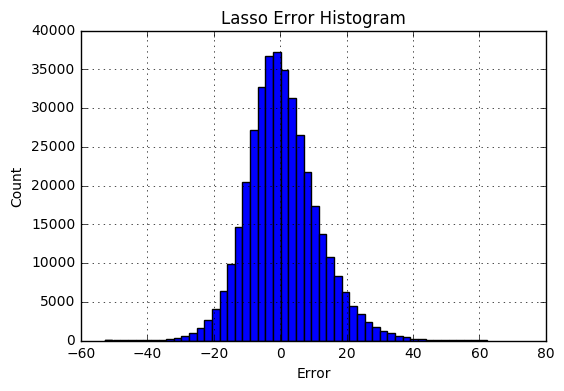

In [121]:
# Error histogram
plt.hist(errors, bins=50)
plt.title("Lasso Error Histogram")
plt.xlabel("Error")
plt.ylabel("Count")
plt.grid()
#plt.savefig("lasso_errors.png")
plt.show()

In [30]:
# Take a look at the most important coefficients
coeffs = l1.coef_

In [34]:
# Figure out how many are zero
print "Forced", (coeffs == 0).sum(), "coefficients to zero of", len(coeffs)

Forced 172 coefficients to zero of 547


In [50]:
# get better names for coeffs
good_names = []
for rcol in relationship_cols:
    for dcol in disease_cols:
        name = str(rcol) + "_" + str(dcol)
        good_names.append(name)
        
col_names = list(train.columns)[0:len(coeffs) - len(good_names)+1] + good_names 

In [55]:
# tie them together, then sort
coeff_tuples = []
for i in range(len(col_names)-1):
    coeff_tuples.append( (col_names[i], coeffs[i]))
# sort it
coeff_tuples = sorted(coeff_tuples, key=lambda x:x[1], reverse=True)
coeff_tuples

[('W', 5.7559865249562616),
 ('<8th grade', 1.0641239256425172),
 ('S_F01', 0.77885121055301287),
 ('White', 0.75389418046003231),
 ('S_G20', 0.72895015507295213),
 ('F01', 0.71661535396047815),
 ('M_G20', 0.68513392087945146),
 ('G20', 0.65834910174635086),
 ('I49', 0.63909572508972246),
 ('D_G20', 0.62359635390475132),
 ('M_F01', 0.59959342749255418),
 ('D_F01', 0.58579819837347569),
 ('R53', 0.49650084821945084),
 ('M_I49', 0.48674913515052914),
 (' Japanese', 0.45934426329847167),
 ('Doctorate/professional', 0.4475101736520285),
 ('Non-Hispanic', 0.40510422826417941),
 ('sex', 0.39651989269377819),
 ('M_G12', 0.34293346198655716),
 ('M_I47', 0.33451748626672273),
 ('S_I49', 0.33057256643422783),
 ('M_C56', 0.31791391162886834),
 ('J15', 0.31048282058350452),
 ('Masters', 0.30997400500393235),
 ('S_I47', 0.29980330870403965),
 ('S_J43', 0.27927645284895858),
 ('Cuban', 0.27613072573543673),
 ('Chinese', 0.26812078399680717),
 ('R57', 0.26288516710988202),
 ('Bachelor', 0.26181729457

# Simple Linear Regression

In [56]:
from sklearn import feature_selection # f_regression for getting p_values

In [58]:
# fit the linear model
lm = linear_model.LinearRegression()
lm.fit(train.drop("age", axis=1), train["age"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [59]:
# get predictions
lm_predictions = lm.predict(test.drop("age", axis=1))
lm_errors = lm_predictions - truth

In [62]:
lm_mse = np.mean(lm_errors**2)
lm_mae = np.mean( np.abs(lm_errors))
lm_25 = np.percentile(lm_errors, 25)
lm_75 = np.percentile(lm_errors, 75)
print "Linear MSE:", lm_mse
print "Linear MAE:", lm_mae
print "25th percentile:", lm_25
print "75th percentile:", lm_75

Linear MSE: 113.157454093
Linear MAE: 8.19100795786
25th percentile: -6.41442871094
75th percentile: 6.71098327637


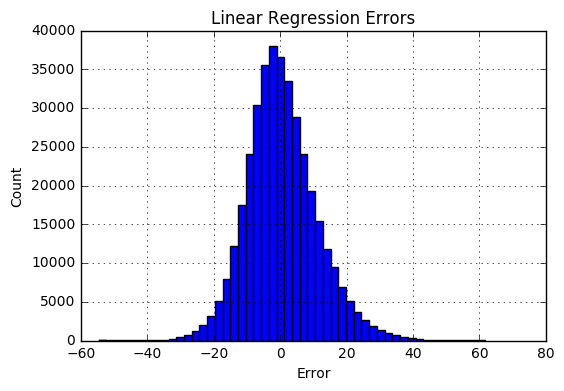

In [63]:
plt.hist(lm_errors, bins=50)
plt.title("Linear Regression Errors")
plt.xlabel("Error")
plt.ylabel("Count")
plt.grid()
plt.show()

## Laso Second Graph Big CV

Fitting with alpha = 1e-05
Fitting with alpha = 0.001
Fitting with alpha = 0.1
Fitting with alpha = 5
Fitting with alpha = 10
Fitting with alpha = 50
Fitting with alpha = 100
Best alpha is: 1e-05


ValueError: x and y must have same first dimension

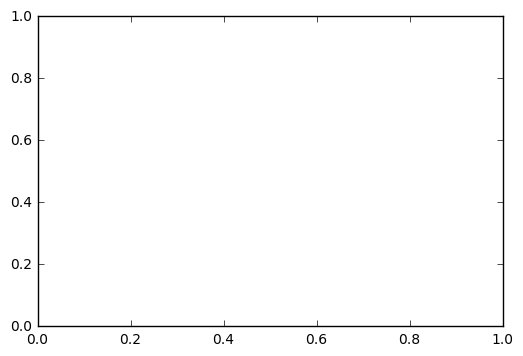

In [114]:
cv_errors2 = []
min_error = np.Inf
best_alpha = 0
#alphas = [.01, .03, .05, .07, .09, .1, .5, 1, 1.5, 2, 3, 4, 6, 9, 10, 15, 20, 25, 30, 50, 70, 100]
#alphas = [.006,.008, .009, .01, .011, .013, .015, .017, .02, .022]
#alphas = [.0001, .0005, .0009, .001, .005, .009, .01, .011, .013, .015, .017, .02, .022, .025, .029, .033, .04]
alphas = [.00001, .001, .1, 5, 10, 50, 100]
for a in alphas:
    print "Fitting with alpha =", a
    # fit the lasso
    l1 = linear_model.Lasso(alpha=a, max_iter=5000) #had a convergence warning
    l1.fit(sdat[1:int(n/10)], train["age"][1:int(n/10)])
    
    predictions = l1.predict(vdat)
    error = np.mean((predictions - VTruth)**2)
    cv_errors2.append(error)
    
    if error < min_error:
        best_alpha = a
        min_error = error
        
print "Best alpha is:", best_alpha


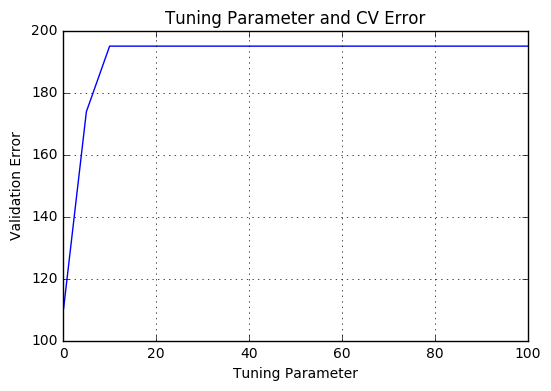

In [116]:

# Graph Errors
plt.plot(alphas, cv_errors2)
plt.xlabel("Tuning Parameter")
plt.ylabel("Validation Error")
plt.title("Tuning Parameter and CV Error")
plt.grid()
plt.savefig("Lasso_CV_Wide.png")
plt.show()

# Ridge Regression

In [122]:
# test fit
l2 = linear_model.Ridge(alpha=.01)
l2.fit(sdat, train["age"])

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='auto', tol=0.001)

In [163]:
len(arange(.0000002, .000002, .0000001))

19

In [183]:
ridge_errors = []
best_alpha_ridge = 0
best_error_ridge = np.inf
r_alphas = arange(.0000002, .0000021, .0000001)
for a in r_alphas:
    print "fitting with alpha: ", a
    # fit
    l2 = linear_model.Ridge(alpha=a)
    l2.fit(sdat[1:int(n/5)], train["age"][1:int(n/5)])
    
    # predictions
    r_pred = l2.predict(vdat)
    e = r_pred - VTruth
    
    #
    r_e = np.mean( (e)**2 )
    ridge_errors.append(r_e)
    if r_e < best_error_ridge:
        best_error_ridge = r_e
        best_alpha_ridge = a   
        
print "best alpha is:", best_alpha_ridge
print "best error is:", best_error_ridge

fitting with alpha:  2e-07
fitting with alpha:  3e-07
fitting with alpha:  4e-07
fitting with alpha:  5e-07
fitting with alpha:  6e-07
fitting with alpha:  7e-07
fitting with alpha:  8e-07
fitting with alpha:  9e-07
fitting with alpha:  1e-06
fitting with alpha:  1.1e-06
fitting with alpha:  1.2e-06
fitting with alpha:  1.3e-06
fitting with alpha:  1.4e-06
fitting with alpha:  1.5e-06
fitting with alpha:  1.6e-06
fitting with alpha:  1.7e-06
fitting with alpha:  1.8e-06
fitting with alpha:  1.9e-06
fitting with alpha:  2e-06
best alpha is: 4e-07
best error is: 108.954249074


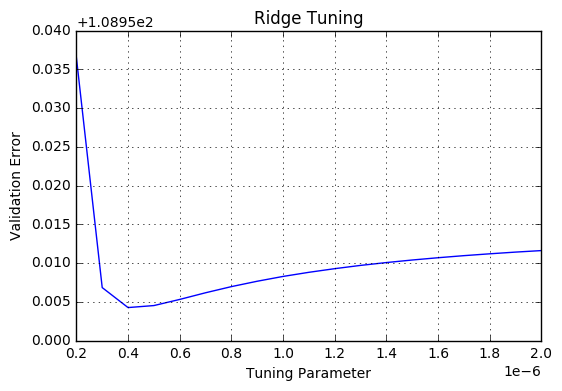

In [187]:
plt.plot(r_alphas, ridge_errors)
plt.title("Ridge Tuning")
plt.xlabel("Tuning Parameter")
plt.ylabel("Validation Error")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.grid()
#plt.savefig("ridge_tuning.png")
plt.show()

Fit the final model with validation param 4e-07

In [169]:
a = 4e-07

1.0000004

In [170]:
# Fit
l2 = linear_model.Ridge(alpha = a)
l2.fit(sdat, train["age"])

Ridge(alpha=1.9e-06, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='auto', tol=0.001)

In [171]:
# Predict
ridge_prediction = l2.predict(tdat)
ridge_error = ridge_prediction - test["age"]

In [174]:
ridge_mse = np.mean( (ridge_error)**2)
ridge_mae = np.mean( np.abs(ridge_error))
ridge_25 = np.percentile( ridge_error, 25)
ridge_75 = np.percentile(ridge_error, 75)

print "Ridge MSE:", ridge_mse
print "Ridge MAE:", ridge_mae
print "25th percentile of error", ridge_25
print "25th percentile of error", ridge_75

Ridge MSE: 113.529229476
Ridge MAE: 8.19403606974
25th percentile of error -6.25810042152
25th percentile of error 6.88682090936


We see that when we finally fit the ridge, the low validation error we got was misleading, and we should have realized that such a small tunning paramter was saying that this was essentially best modeled by a standard linear regression.

# SVM 

In [188]:
from sklearn import svm

In [ ]:
SVM = svm.SVR(C = 1)
SVM.fit(sdat, train["age"])

The above fucked up the kernel, god damn 